## Algoritmo Previsão Range de Preços de Dispositivos Móveis

### Importando as bibliotecas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Importando e tratando a base de dados

In [3]:
df = pd.read_csv(r'https://raw.githubusercontent.com/torvess/precos_dispositivos_moveis/main/train.csv')
dados = df.copy()

In [4]:
dados.head(3)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2


In [5]:
print(f'Número de linhas {dados.shape[0]}, número de colunas {dados.shape[1]}')

Número de linhas 2000, número de colunas 21


In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [7]:
dados.isnull().sum().sum()

0

In [8]:
dados.duplicated().sum()

0

### Análise exploratória dos dados

In [9]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


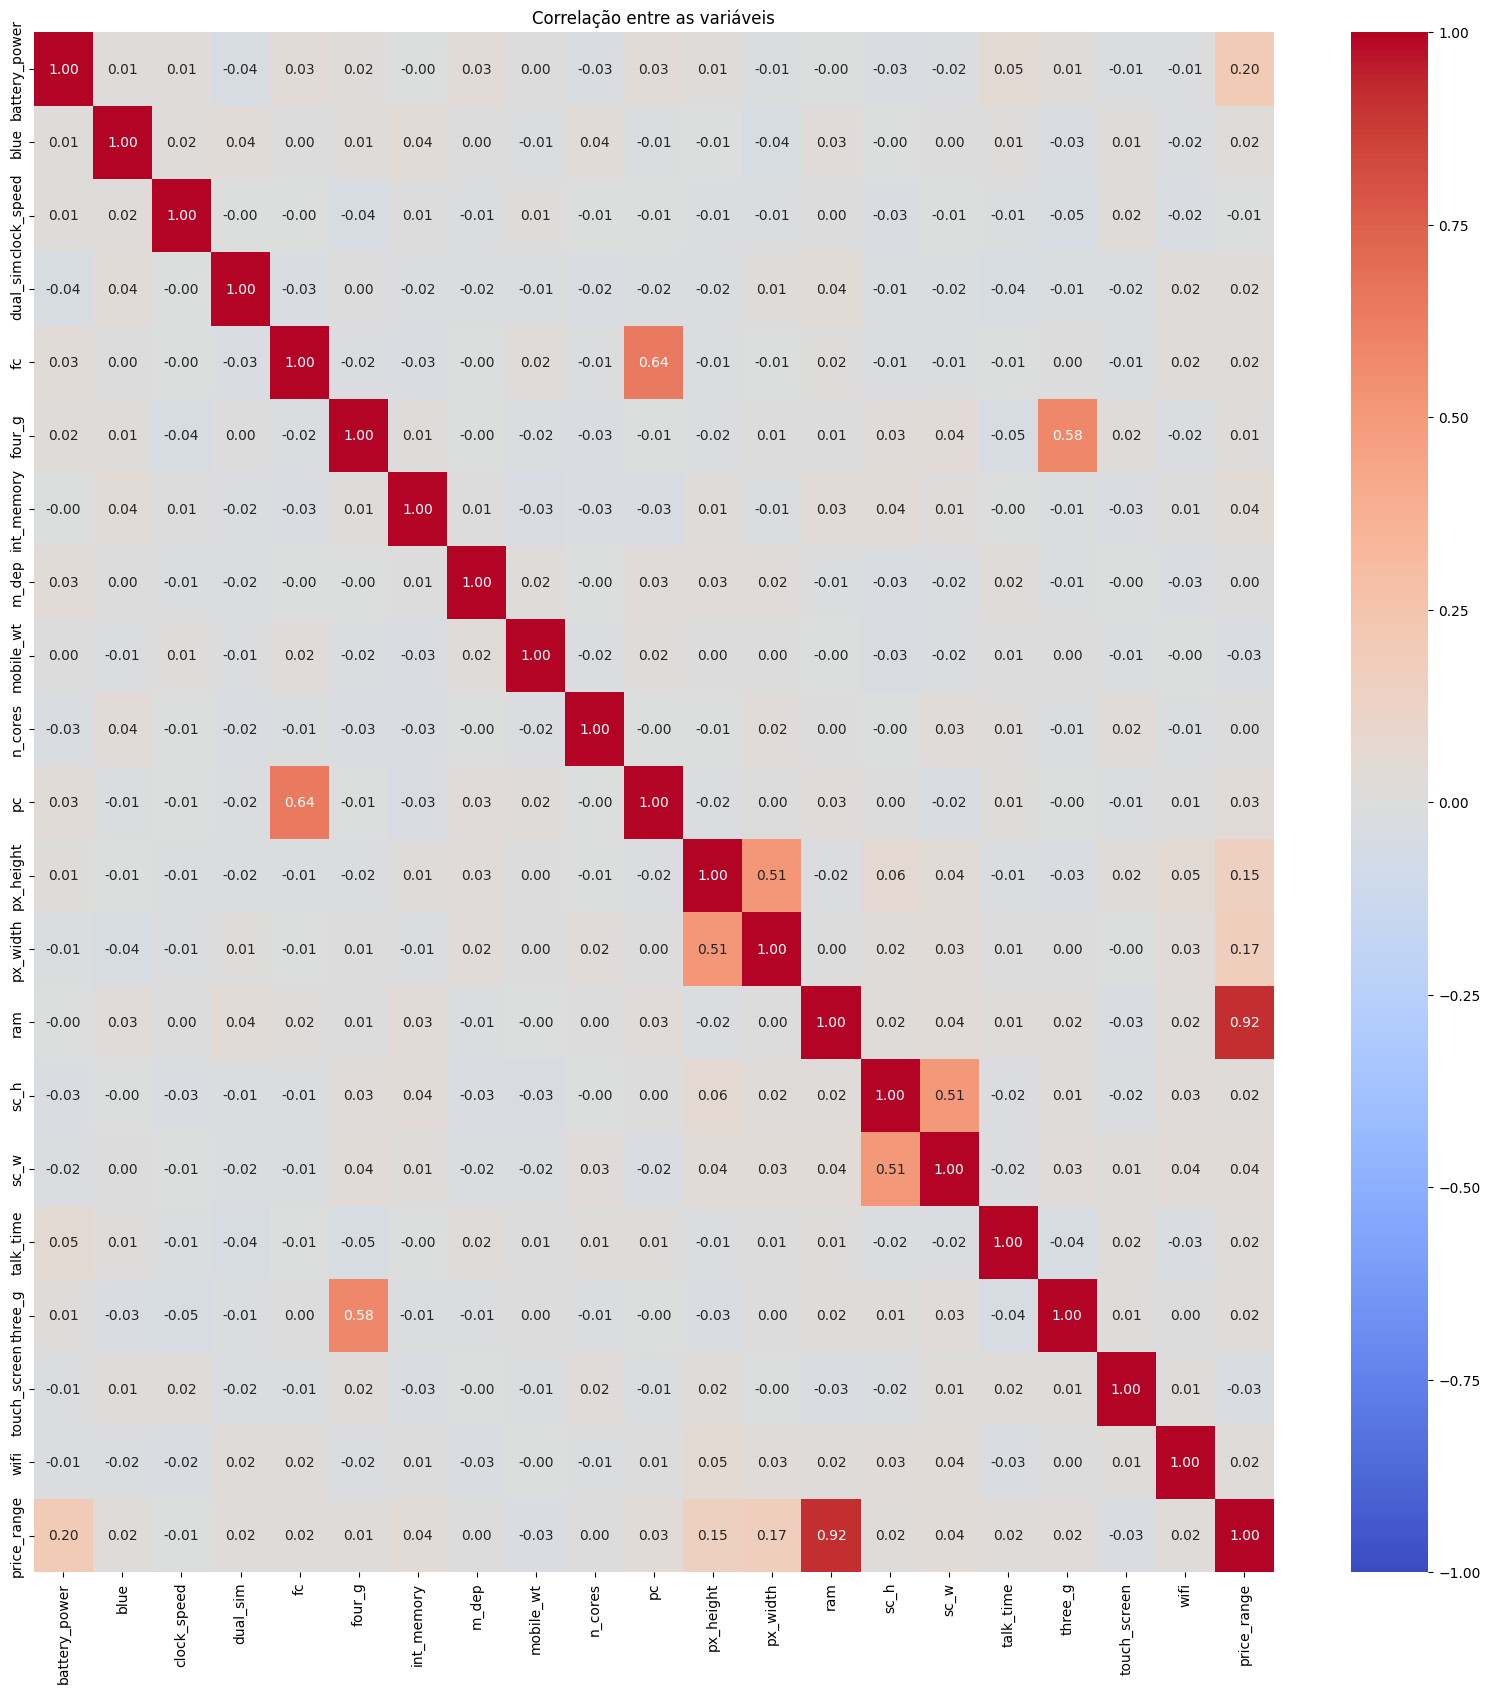

In [10]:
corr_matrix = dados.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')

plt.title('Correlação entre as variáveis')
plt.show()


In [11]:
corr_matrix['price_range'].sort_values(ascending=False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

In [12]:
dados = dados[['ram', 'battery_power', 'px_width', 'px_height', 'price_range']]

In [13]:
# grafico de dispersão
def plot_scater(df, x_axis, y_axis):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x=df[x_axis], y=df[y_axis], color='blue')
    plt.title(f'Relação entre {x_axis} e {y_axis}')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()

# grafico de boxplot
def plot_boxplot(df, x_axis):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df, x=x_axis, ax=ax, color='darkblue')
    sns.violinplot(data=df, x=x_axis, ax=ax, color='lightgray')
    ax.set_title('Visualização Boxplot e ViolinPlot')

    plt.show()

# grafico barplot
def plot_barplot(df, x_axis, y_axis):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=df, x=x_axis, y=y_axis)
    plt.title(f'{x_axis} vs {y_axis}')

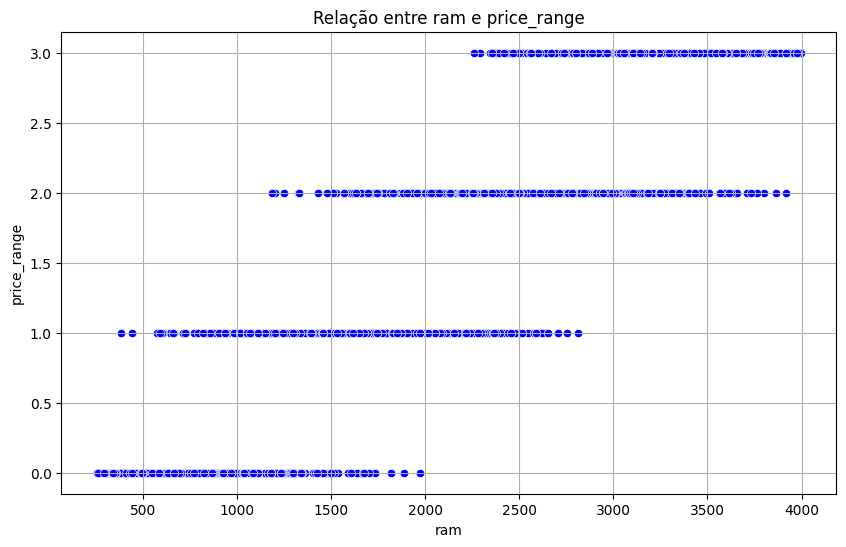

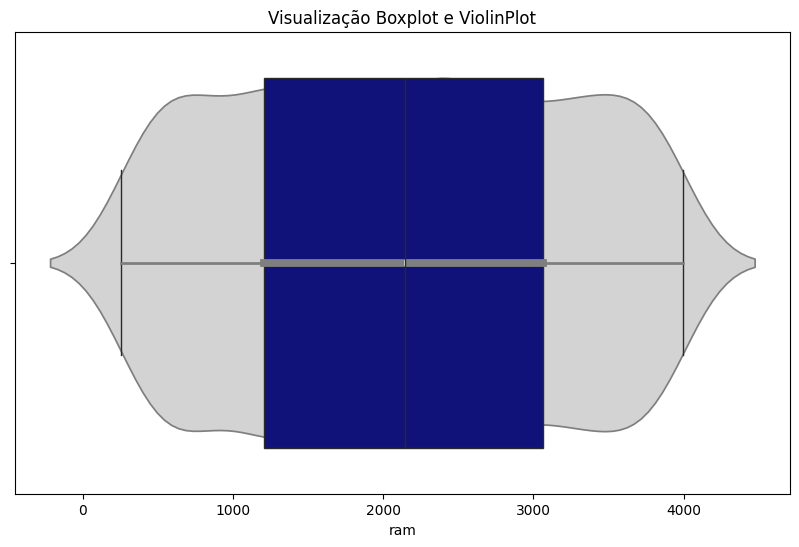

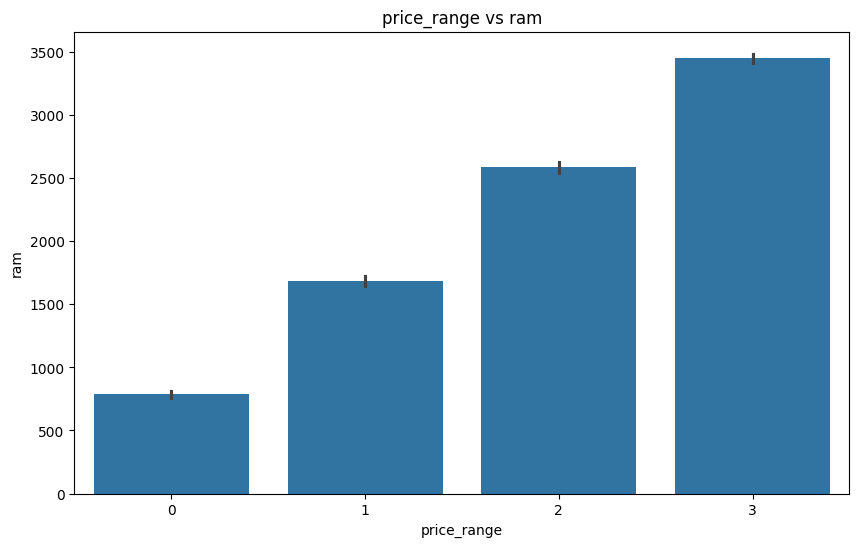

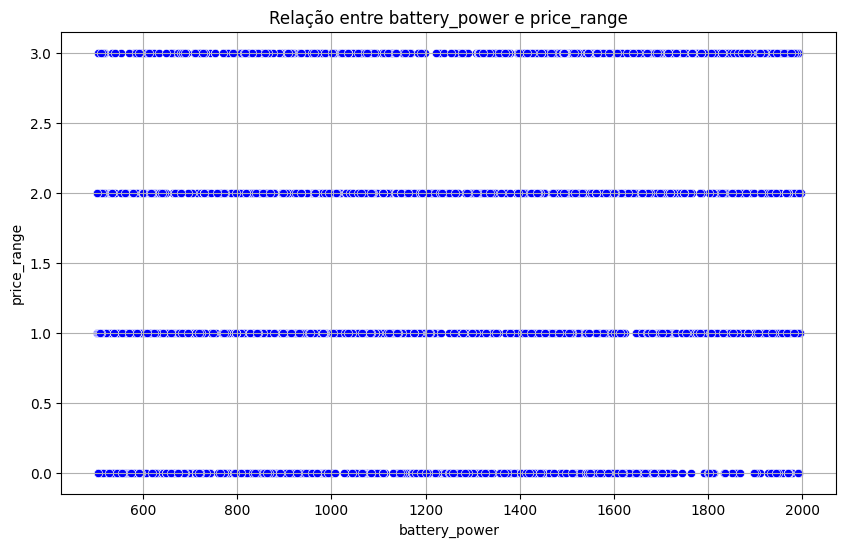

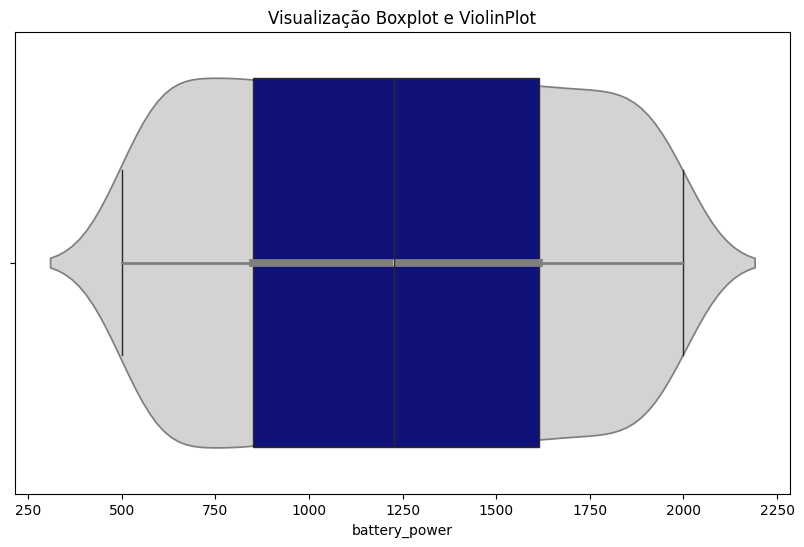

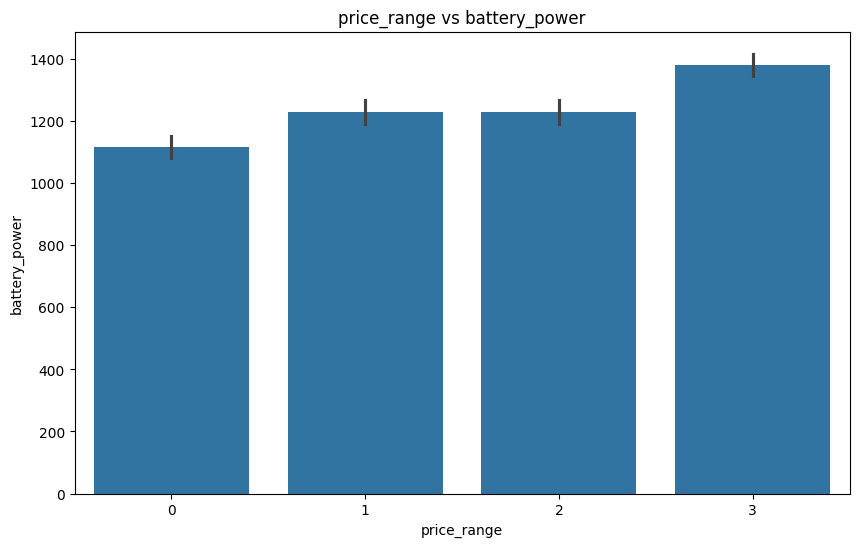

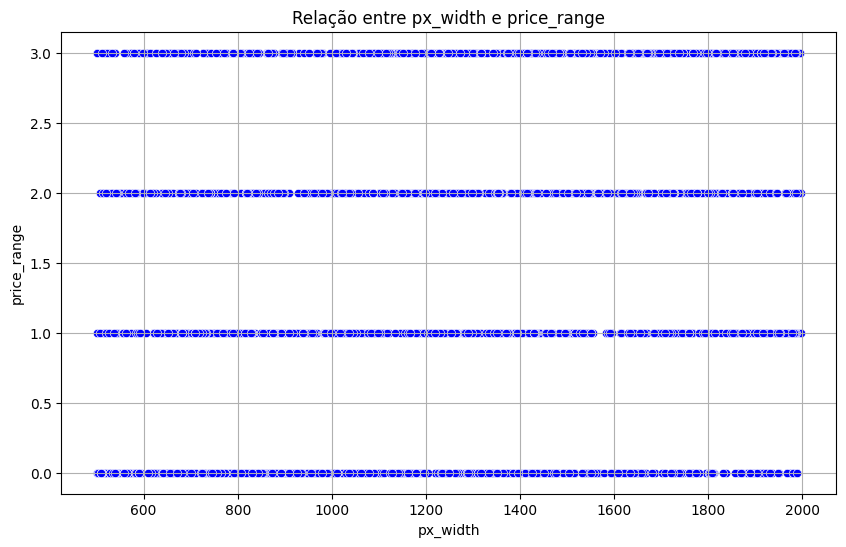

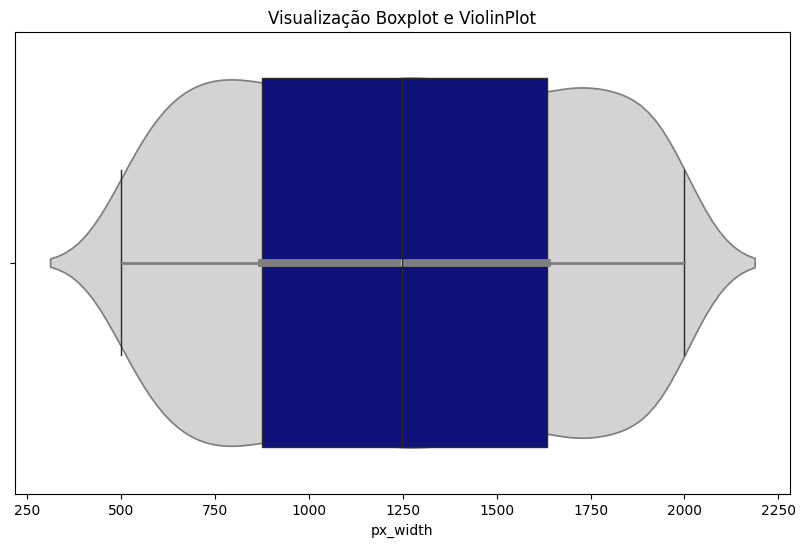

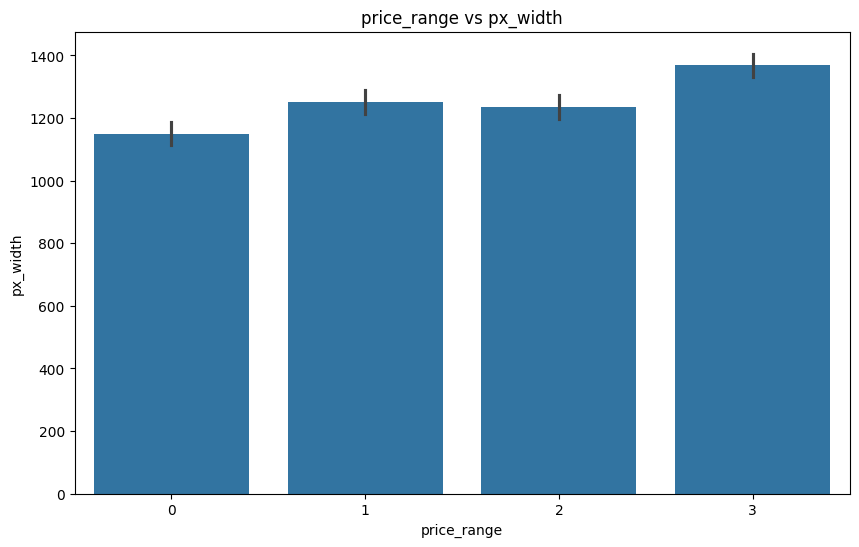

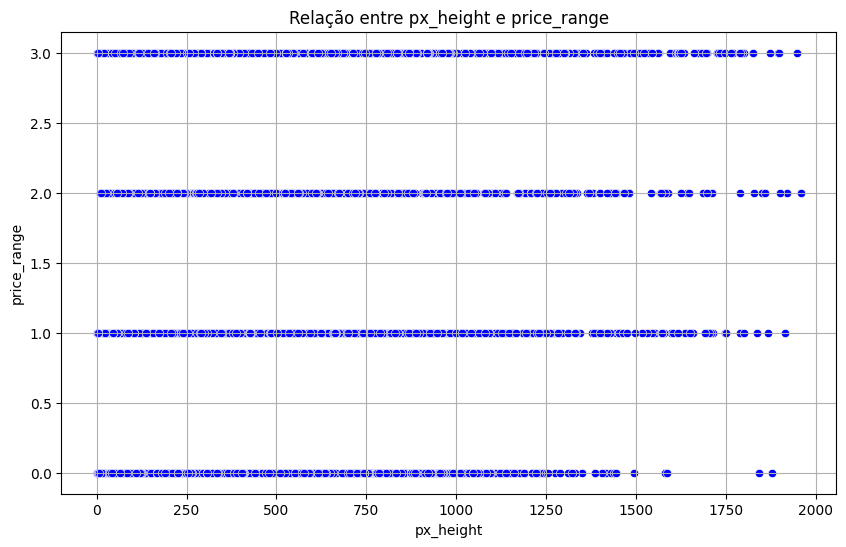

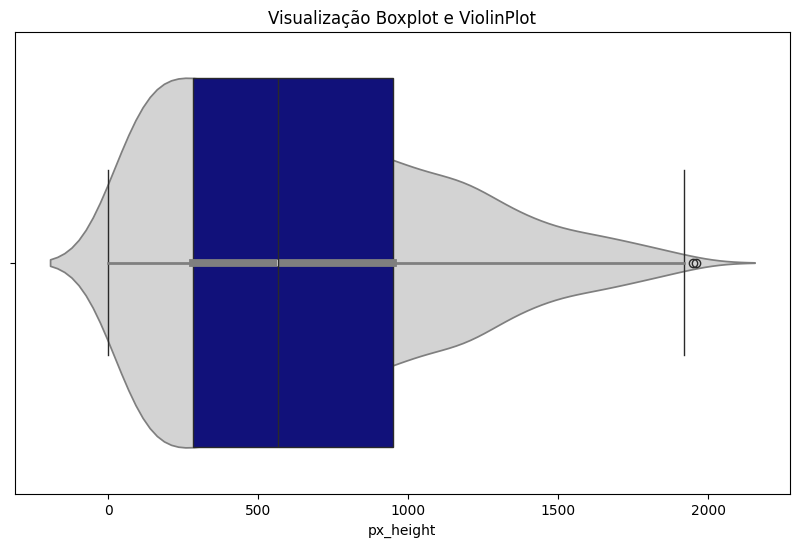

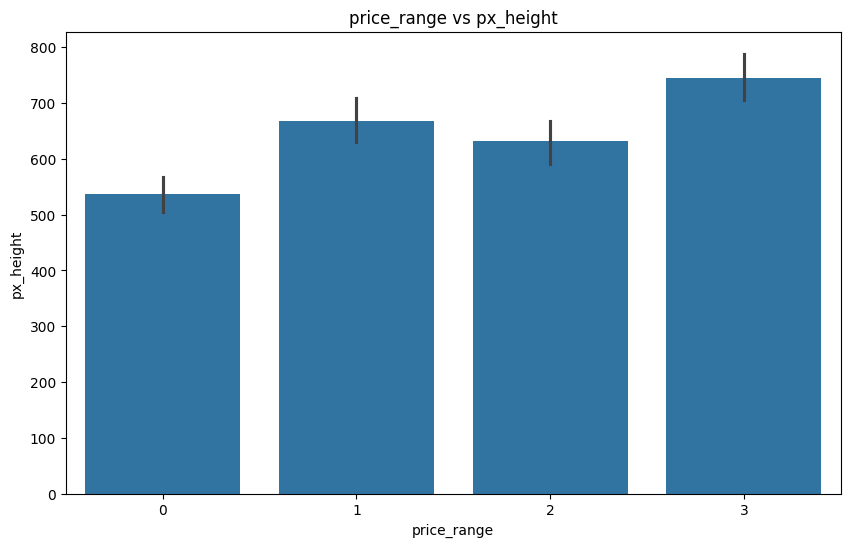

In [14]:
# exibindo os graficos para todas as colunas
for coluna in dados.columns:
    if coluna != 'price_range':
        plot_scater(dados, coluna, 'price_range')
        plot_boxplot(dados, coluna)
        plot_barplot(dados, 'price_range', coluna)

### Criação dos modelos

definindo funções necessárias

In [15]:
def fit_score(models,x,y):
    test_size_list = [0.2,0.5,0.8,0.12,0.15]
    classes = []
    for model in models:
        classes.append(str(type(model)).split('_')[1].split('.')[1])
    classes.append('Test Ratio')
    result = pd.DataFrame(columns=classes)
    
    for (index,test_size) in enumerate(test_size_list):
        scores = []
        X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=42)
        for model in models:
            model.fit(X_train,y_train)
            scores.append(model.score(X_test,y_test))
        scores.append(test_size)
        result.loc[index] = scores
        
    print(result,end='\n=====================================')

In [16]:
def evaluate(models,x_train,x_test,y_train,y_test):
    
    length = len(models)
    
    for model in models:
    
        model.fit(x_train,y_train)

        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print("Train Accuracy Score: {%.2f}"%accuracy_score(y_train,train_pred))
        print("Train Precision Score: {%.2f}"%precision_score(y_train,train_pred,average='macro'))
        print("Train Recall Score: {%.2f}"%recall_score(y_train,train_pred,average='macro'))

        print("\n")
        
        print("Test Accuracy Score: {%.2f}"%accuracy_score(y_test,test_pred))
        print("Test Precision Score: {%.2f}"%precision_score(y_test,test_pred,average='macro'))
        print("Test Recall Score: {%.2f}"%recall_score(y_test,test_pred,average='macro'))
        
        print("==============================================")

In [17]:
def validate_w_shuffle(model,x,y,random_state=42,shuffle=True,n_splits=10,scoring='accuracy'):
    splitter = StratifiedKFold(n_splits=n_splits,random_state=random_state,shuffle=shuffle)
    counter = 1
    
    for train_index,test_index in splitter.split(x,y):
        X_train_folds = x[train_index]
        X_valid_fold = x[test_index]
        y_train_folds = y.iloc[train_index]
        y_valid_fold = y.iloc[test_index]
        
        train_pred = model.predict(X_train_folds)
        valid_pred = model.predict(X_valid_fold)
        
        if scoring == 'accuracy':
            print('Train Accuracy: {}'.format(accuracy_score(y_train_folds,train_pred)))
            print("Validate Accuracy: {}".format(accuracy_score(y_valid_fold,valid_pred)))
            
        elif scoring == 'precision':
            print('Train Precision: {}'.format(precision_score(y_train_folds,train_pred,average='macro')))
            print("Validate Precision: {}".format(precision_score(y_valid_fold,valid_pred,average='macro')))

        elif scoring == 'recall':
            print('Train Recall: {}'.format(recall_score(y_train_folds,train_pred,average='macro')))
            print("Validate Recall: {}".format(recall_score(y_valid_fold,valid_pred,average='macro')))
            
        else:
            print("Scoring parameter must be : [accuracy,precision,recall]")
            break
            
        print("=========={}==========".format(counter))
        counter = counter+1

Divisão das bases de treino e teste, padronização dos dados

In [18]:
X = dados.drop(columns='price_range', axis=1)
y = dados['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [19]:
models = [LinearSVC(random_state=42,C=1e-3,max_iter=1500),
          SVC(C=1e-3,random_state=42),
          GradientBoostingClassifier(learning_rate=1e-3)
        ]

In [20]:
evaluate(models, X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy Score: {0.58}
Train Precision Score: {0.62}
Train Recall Score: {0.59}


Test Accuracy Score: {0.64}
Test Precision Score: {0.71}
Test Recall Score: {0.61}
Train Accuracy Score: {0.26}
Train Precision Score: {0.06}
Train Recall Score: {0.25}


Test Accuracy Score: {0.23}
Test Precision Score: {0.06}
Test Recall Score: {0.25}
Train Accuracy Score: {0.80}
Train Precision Score: {0.81}
Train Recall Score: {0.80}


Test Accuracy Score: {0.77}
Test Precision Score: {0.78}
Test Recall Score: {0.77}


In [21]:
model = GradientBoostingClassifier(learning_rate=1e-3)
model.fit(X_train_scaled,y_train)

GradientBoostingClassifier(learning_rate=0.001)

In [22]:
validate_w_shuffle(model,X_train_scaled,y_train,scoring='accuracy')

Train Accuracy: 0.7923611111111111
Validate Accuracy: 0.85625
==========1==========
Train Accuracy: 0.7979166666666667
Validate Accuracy: 0.80625
==========2==========
Train Accuracy: 0.7993055555555556
Validate Accuracy: 0.79375
==========3==========
Train Accuracy: 0.8041666666666667
Validate Accuracy: 0.75
==========4==========
Train Accuracy: 0.7944444444444444
Validate Accuracy: 0.8375
==========5==========
Train Accuracy: 0.8006944444444445
Validate Accuracy: 0.78125
==========6==========
Train Accuracy: 0.8013888888888889
Validate Accuracy: 0.775
==========7==========
Train Accuracy: 0.7951388888888888
Validate Accuracy: 0.83125
==========8==========
Train Accuracy: 0.8013888888888889
Validate Accuracy: 0.775
==========9==========
Train Accuracy: 0.8006944444444445
Validate Accuracy: 0.78125
==========10==========


In [23]:
param_grid = {
    'n_estimators':[100,150,300,250],
    'learning_rate':[1e-4,1e-3,1e-2,1e-1,1,10,100],
    'max_depth':[2,3,5,4],
}
#it takes a long time
grid_cv = GridSearchCV(estimator=GradientBoostingClassifier(),param_grid=param_grid,cv=3,scoring='accuracy',n_jobs=-1)
grid_cv.fit(X_train_scaled,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                           100],
                         'max_depth': [2, 3, 5, 4],
                         'n_estimators': [100, 150, 300, 250]},
             scoring='accuracy')

In [24]:
best_params = grid_cv.best_params_
best_params

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}

In [25]:
best_model = GradientBoostingClassifier(learning_rate=0.1,max_depth=2,n_estimators=150)
best_model.fit(X_train_scaled,y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=150)

In [26]:
validate_w_shuffle(best_model,X_train_scaled,y_train)

Train Accuracy: 0.9826388888888888
Validate Accuracy: 0.9875
==========1==========
Train Accuracy: 0.98125
Validate Accuracy: 1.0
==========2==========
Train Accuracy: 0.9826388888888888
Validate Accuracy: 0.9875
==========3==========
Train Accuracy: 0.9840277777777777
Validate Accuracy: 0.975
==========4==========
Train Accuracy: 0.98125
Validate Accuracy: 1.0
==========5==========
Train Accuracy: 0.9826388888888888
Validate Accuracy: 0.9875
==========6==========
Train Accuracy: 0.9861111111111112
Validate Accuracy: 0.95625
==========7==========
Train Accuracy: 0.9833333333333333
Validate Accuracy: 0.98125
==========8==========
Train Accuracy: 0.9819444444444444
Validate Accuracy: 0.99375
==========9==========
Train Accuracy: 0.9854166666666667
Validate Accuracy: 0.9625
==========10==========


In [27]:
test_pred = best_model.predict(X_test_scaled)
print('Accuracy: {}'.format(accuracy_score(y_test,test_pred)))
print("Precision: %.2f"%precision_score(y_test,test_pred,average='macro'))
print("Recall: %.2f"%recall_score(y_test,test_pred,average='macro'))

Accuracy: 0.9075
Precision: 0.91
Recall: 0.91
